In [42]:
import PyMEGABASE as PYMB
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
import os
from tempfile import TemporaryDirectory
import copy
import time
import seaborn as sns
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches

In [43]:
class NoiseScheduler(nn.Module):  # Inherit from nn.Module for proper device handling
    """Handles noise scheduling for diffusion process"""
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super().__init__()
        self.num_timesteps = num_timesteps
        
        # Create noise schedule
        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        # Register as buffers so they move with the model to GPU/CPU
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        
    def add_noise(self, x, timesteps):
        """Add noise to input data at specified timesteps"""
        batch_size = x.shape[0]
        noise = torch.randn_like(x)
        
        # Get alpha values for the timesteps - now both tensors are on same device
        alpha_cumprod = self.alphas_cumprod[timesteps].view(batch_size, 1)
        
        # Add noise: x_t = sqrt(alpha_cumprod) * x + sqrt(1 - alpha_cumprod) * noise
        noisy_x = torch.sqrt(alpha_cumprod) * x + torch.sqrt(1 - alpha_cumprod) * noise
        return noisy_x, noise

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TimestepEmbedding(nn.Module):
    """Embed diffusion timesteps"""
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        
    def forward(self, timesteps):
        # Sinusoidal embedding for timesteps
        half_dim = self.d_model // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        
        # MLP
        emb = F.silu(self.linear1(emb))
        emb = self.linear2(emb)
        return emb

class ConditionalTransformerBlock(nn.Module):
    """Transformer block with conditioning"""
    def __init__(self, d_model: int, nhead: int, d_hid: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, d_hid)
        self.linear2 = nn.Linear(d_hid, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Conditioning layers
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_model, d_model * 2)
        )
        self.class_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_model, d_model * 2)
        )
        
    def forward(self, x, time_emb, class_emb, src_mask=None):
        # Time and class conditioning
        time_scale, time_shift = self.time_mlp(time_emb).chunk(2, dim=-1)
        class_scale, class_shift = self.class_mlp(class_emb).chunk(2, dim=-1)
        
        # Self-attention with residual
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=src_mask)
        x = x + self.dropout(attn_output)
        
        # Apply conditioning
        x = x * (1 + time_scale.unsqueeze(1) + class_scale.unsqueeze(1))
        x = x + time_shift.unsqueeze(1) + class_shift.unsqueeze(1)
        
        # Feed-forward with residual
        x_norm = self.norm2(x)
        ff_output = self.linear2(F.relu(self.linear1(x_norm)))
        x = x + self.dropout(ff_output)
        
        return x

class DiffusionTransformerModel(nn.Module):
    """Transformer model for conditional diffusion"""
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, features: int, num_classes: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'DiffusionTransformer'
        self.d_model = d_model
        self.num_classes = num_classes
        
        # Embeddings
        self.encoder = nn.Embedding(ntoken, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.time_embedding = TimestepEmbedding(d_model)
        self.class_embedding = nn.Embedding(num_classes, d_model)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            ConditionalTransformerBlock(d_model, nhead, d_hid, dropout)
            for _ in range(nlayers)
        ])
        
        # Output layers for denoising
        self.output_norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, ntoken)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, noisy_x: Tensor, timesteps: Tensor, class_labels: Tensor, src_mask: Tensor = None):
        """
        Forward pass for denoising
        Args:
            noisy_x: Noisy input sequences [batch_size, seq_len]
            timesteps: Diffusion timesteps [batch_size]
            class_labels: Class conditioning [batch_size]
            src_mask: Attention mask
        """
        # Embed inputs
        x = self.encoder(noisy_x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        # Embed timesteps and classes
        time_emb = self.time_embedding(timesteps)
        class_emb = self.class_embedding(class_labels)
        
        # Apply transformer blocks with conditioning
        for block in self.transformer_blocks:
            x = block(x, time_emb, class_emb, src_mask)
        
        # Output projection to predict noise
        x = self.output_norm(x)
        noise_pred = self.output_projection(x)
        
        return noise_pred

class DiffusionClassifier:
    """Classifier using diffusion denoising"""
    def __init__(self, model, noise_scheduler, num_classes, device):
        self.model = model
        self.noise_scheduler = noise_scheduler
        self.num_classes = num_classes
        self.device = device
        
    def classify(self, x, num_noise_levels=50):
        """
        Classify using diffusion denoising
        Args:
            x: Input sequences [batch_size, seq_len]
            num_noise_levels: Number of noise levels to test
        """
        self.model.eval()
        batch_size = x.shape[0]
        
        # Sample random noise levels
        timesteps = torch.randint(0, self.noise_scheduler.num_timesteps, 
                                (num_noise_levels,), device=self.device)
        
        reconstruction_errors = torch.zeros(batch_size, self.num_classes, device=self.device)
        
        with torch.no_grad():
            for t in timesteps:
                # Add noise to input
                t_batch = t.repeat(batch_size)
                #noisy_x, true_noise = self.noise_scheduler.add_noise(x.float(), t_batch)
                noisy_x, true_noise = self.noise_scheduler.add_noise(x.float().to(self.device), t_batch)
                noisy_x = noisy_x.long().clamp(0, self.model.encoder.num_embeddings - 1)
                
                # Test each class condition
                for class_idx in range(self.num_classes):
                    class_labels = torch.full((batch_size,), class_idx, device=self.device)
                    
                    # Predict noise
                    predicted_noise = self.model(noisy_x, t_batch, class_labels)
                    
                    # Calculate reconstruction error
                    error = F.mse_loss(predicted_noise, true_noise.unsqueeze(-1).expand_as(predicted_noise), 
                                     reduction='none').mean(dim=(1, 2))
                    reconstruction_errors[:, class_idx] += error
        
        # Average errors across noise levels
        reconstruction_errors /= num_noise_levels
        
        # Select class with minimum reconstruction error
        predicted_classes = torch.argmin(reconstruction_errors, dim=1)
        
        return predicted_classes, reconstruction_errors


=== Multi-Cell Line Analysis ===
Loading best validation model...

=== Processing IMR-90 ===
    ****************************************************************************************    
       **** *** *** *** *** *** *** *** PyMEGABASE-1.0.0 *** *** *** *** *** *** *** ****       
       **** *** *** *** *** *** *** *** PyMEGABASE-1.0.0 *** *** *** *** *** *** *** ****       
       **** *** *** *** *** *** *** *** PyMEGABASE-1.0.0 *** *** *** *** *** *** *** ****       
    ****************************************************************************************    

              The PyMEGABASE class performs the prediction of genomic annotations               
              based on 1D data tracks of Chip-Seq and RNA-Seq. The input data is                
                                obtained from ENCODE data base.                                 
                          PyMEGABASE description is described in: TBD                           

        This package is the prod

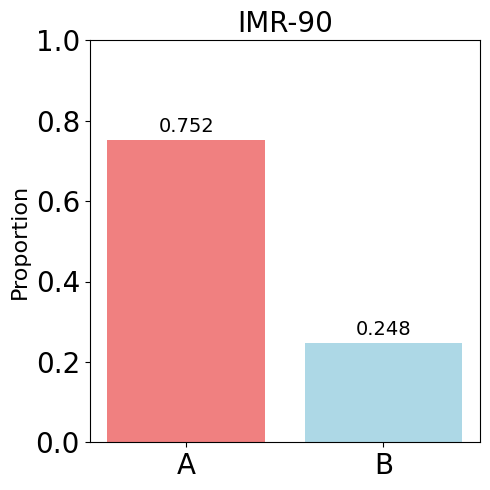

Creating 5-class distribution plots...


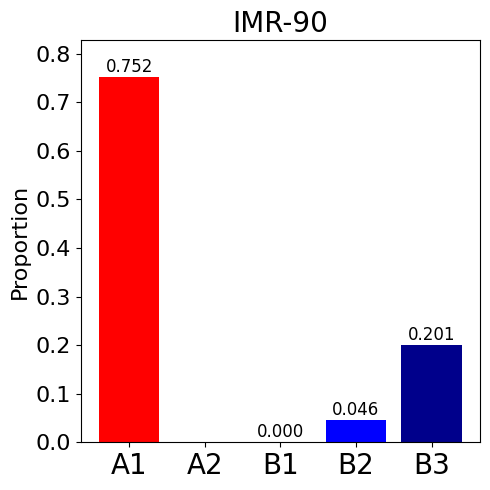

Creating timeline plots...


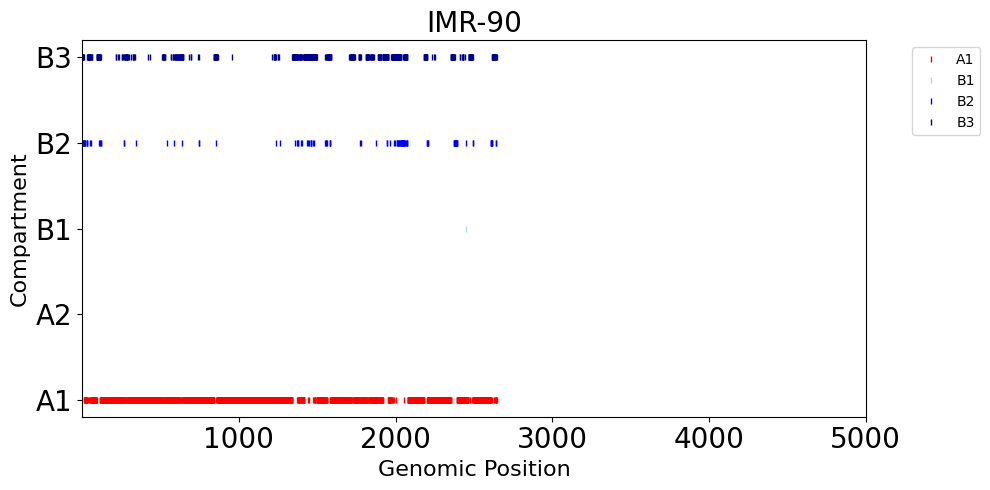

In [92]:
def get_test_set_diffusion(cellname, n_neighbors=2, chrms=range(1,23)):
    """
    Get test set for diffusion classifier using PyMEGABASE
    Args:
        cellname: Cell line name
        n_neighbors: Number of neighboring regions
        chrms: Chromosomes to include
    """
    # Initialize PyMEGABASE (same as original)
    _pymb = PYMB.PyMEGABASE(
        cell_line=cellname, 
        assembly='GRCh38', 
        organism='human',
        signal_type='signal p-value',
        ref_cell_line_path='./GM12878_hg19_test', 
        #cell_line_path=cellname+'_GRCh38_zscore',
        histones=True,
        tf=False,
        small_rna=False,
        total_rna=False,
        n_states=10,
        res=50
    )
    
    print('looking for data in:', _pymb.cell_line_path)
    
    # Load test data for specified chromosomes
    test_cell = []
    for chr in chrms:
        test_cell.append(_pymb.test_set(chr=chr, silent=True))
    test_cell = np.concatenate(test_cell, axis=1)
    print(f"Concatenated test_cell shape: {test_cell.shape}")

    
    # Populate prediction set (same logic as original)
    tmp = []
    nfeatures = len(np.loadtxt(_pymb.cell_line_path+'/unique_exp.txt', dtype=str))
    print(len(test_cell[0]) - n_neighbors, 'loop')
    for l in range(n_neighbors, len(test_cell[0]) - n_neighbors):
        tmp.append(np.insert(
            np.concatenate(test_cell[nfeatures*2:nfeatures*3, l-n_neighbors:l+n_neighbors+1]), 
            0, 1
        ))
    
    testmatrix = np.array(tmp).T
    nfeatures = (2*n_neighbors + 1) * nfeatures
    test_set = testmatrix.T-1
    test_data = torch.tensor(test_set.astype(float))
    print(f"Final test set size: {test_data.shape}")
    print(f"Number of samples: {len(test_data)}")
    print(f"Features per sample: {test_data.shape[1] - 1}")    
    
    return test_data

def predict_cell_line_diffusion(classifier, test_data, device, batch_size=16):
    """
    Make predictions on cell line data using diffusion classifier
    Args:
        classifier: DiffusionClassifier instance
        test_data: Test data tensor
        device: torch device
        batch_size: Batch size for prediction
    """
    print(f"Making predictions on {len(test_data)} samples...")
    
    # Process in batches
    all_predictions = []
    num_batches = (len(test_data) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(test_data))
            
            batch_data = test_data[start_idx:end_idx, 1:].to(device)  # Skip label column
            
            # Get predictions with reduced noise levels for speed
            predictions, _ = classifier.classify(batch_data, num_noise_levels=100)
            all_predictions.append(predictions.cpu())
            
            if batch_idx % 20 == 0:
                print(f"Processed {batch_idx}/{num_batches} batches", end='\r')
    
    predictions = torch.cat(all_predictions).numpy()
    print(f"\nCompleted predictions for {len(predictions)} samples")
    
    return predictions

def analyze_multiple_cell_lines():
    """
    Complete analysis across multiple cell lines
    """
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model parameters
    ntokens = 11
    emsize = 128
    d_hid = 64
    nlayers = 2
    nhead = 8
    dropout = 0.01
    num_classes = 5
    nfeatures=len(np.loadtxt('IMR-90_GRCh38'+'/unique_exp.txt',dtype=str))*5
    # Create model and noise scheduler
    diffusion_model = DiffusionTransformerModel(
        ntoken=ntokens,
        d_model=emsize,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        features=nfeatures,
        num_classes=num_classes,
        dropout=dropout
    ).to(device)
    
    noise_scheduler = NoiseScheduler(num_timesteps=1000).to(device)
    n_neighbors=15
    try:
        # Load the best validation model
        print("Loading best validation model...")
        checkpoint = torch.load('best_val_diffusion_model.pt')
        diffusion_model.load_state_dict(checkpoint['model_state_dict'])
        noise_scheduler.load_state_dict(checkpoint['noise_scheduler_state_dict'])
        
        # Create classifier
        classifier = DiffusionClassifier(diffusion_model, noise_scheduler, num_classes, device)
        
        # Cell lines to analyze
        #cell_lines = ['K562', 'IMR-90', 'A549', 'HepG2']
        cell_lines = ['IMR-90']
        subc = {}
        
        # Get predictions for each cell line
        for name in cell_lines:
            print(f"\n=== Processing {name} ===")
            
            try:
                # Get test data for this cell line
                ts = get_test_set_diffusion(name, n_neighbors, chrms=[10])  # Using chromosome 10
                
                # Make predictions
                predictions = predict_cell_line_diffusion(classifier, ts, device)
                subc[name] = predictions
                
                # Print summary statistics (same as original)
                u, c = np.unique(subc[name], return_counts=True)
                print(f"{name} - Classes: {u}, Counts: {c}")
                print(f"A: {np.sum(c[:2])} - B: {np.sum(c[2:])}")
                
            except Exception as e:
                print(f"Error processing {name}: {e}")
                continue
        
        return subc
        
    except FileNotFoundError:
        print("Model checkpoint 'best_val_diffusion_model.pt' not found.")
        print("Please train the model first.")
        return None

def plot_cell_line_results(subc):
    """
    Create all visualization plots for cell line results
    Args:
        subc: Dictionary with cell line predictions
    """
    cell_lines = list(subc.keys())
    
    # 1. A vs B compartment distribution plots
    print("Creating A vs B compartment plots...")
    for name in cell_lines:
        if subc[name] is not None:
            plt.figure(figsize=(5, 5))
            
            # Calculate A vs B proportions
            a_prop = np.sum(subc[name] < 2) / len(subc[name])
            b_prop = np.sum(subc[name] >= 2) / len(subc[name])
            
            plt.bar(['A', 'B'], [a_prop, b_prop], color=['lightcoral', 'lightblue'])
            plt.yticks(fontsize=20)
            plt.title(name, fontsize=20)
            plt.xticks(fontsize=20)
            plt.ylabel('Proportion', fontsize=16)
            plt.ylim([0, 1])
            
            # Add proportion text on bars
            plt.text(0, a_prop + 0.02, f'{a_prop:.3f}', ha='center', fontsize=14)
            plt.text(1, b_prop + 0.02, f'{b_prop:.3f}', ha='center', fontsize=14)
            
            plt.tight_layout()
            plt.savefig(f'{name}_AB_distribution.png', bbox_inches='tight', dpi=300)
            plt.show()
    
    # 2. Full 5-class distribution plots
    print("Creating 5-class distribution plots...")
    for name in cell_lines:
        if subc[name] is not None:
            plt.figure(figsize=(5, 5))
            
            u, c = np.unique(subc[name], return_counts=True)
            proportions = c / len(subc[name])
            
            # Create bar plot with class-specific colors
            colors = ['red', 'orange', 'lightblue', 'blue', 'darkblue']
            plt.bar(u, proportions, color=[colors[i] for i in u])
            
            plt.title(name, fontsize=20)
            plt.xticks([0, 1, 2, 3, 4], ['A1', 'A2', 'B1', 'B2', 'B3'], fontsize=20)
            plt.yticks(fontsize=16)
            plt.ylabel('Proportion', fontsize=16)
            plt.ylim([0, max(proportions) * 1.1])
            
            # Add proportion text on bars
            for i, (class_idx, prop) in enumerate(zip(u, proportions)):
                plt.text(class_idx, prop + 0.01, f'{prop:.3f}', ha='center', fontsize=12)
            
            plt.tight_layout()
            plt.savefig(f'{name}_5class_distribution.png', bbox_inches='tight', dpi=300)
            plt.show()

def quick_cell_line_analysis(cell_lines=['K562'], n_neighbors=2, max_samples=1000):
    """
    Quick analysis on subset of data for faster testing
    Args:
        cell_lines: List of cell lines to analyze
        max_samples: Maximum samples per cell line
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model parameters
    ntokens = 11
    emsize = 128
    d_hid = 64
    nlayers = 2
    nhead = 8
    dropout = 0.01
    num_classes = 5
    
    # Create model
    diffusion_model = DiffusionTransformerModel(
        ntoken=ntokens,
        d_model=emsize,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        features=nfeatures,
        num_classes=num_classes,
        dropout=dropout
    ).to(device)
    
    noise_scheduler = NoiseScheduler(num_timesteps=1000).to(device)
    
    try:
        # Load model
        checkpoint = torch.load('best_val_diffusion_model.pt')
        diffusion_model.load_state_dict(checkpoint['model_state_dict'])
        noise_scheduler.load_state_dict(checkpoint['noise_scheduler_state_dict'])
        
        classifier = DiffusionClassifier(diffusion_model, noise_scheduler, num_classes, device)
        
        subc = {}
        
        for name in cell_lines:
            print(f"\n=== Quick analysis for {name} ===")
            
            try:
                # Get test data
                ts = get_test_set_diffusion(name, n_neighbors, chrms=[1])
                
                # Use subset for speed
                subset_size = min(max_samples, len(ts))
                ts_subset = ts[:subset_size]
                
                # Make predictions
                predictions = predict_cell_line_diffusion(classifier, ts_subset, device, batch_size=8)
                subc[name] = predictions
                
                # Quick stats
                u, c = np.unique(predictions, return_counts=True)
                print(f"{name} (n={subset_size}) - Classes: {u}, Counts: {c}")
                
            except Exception as e:
                print(f"Error processing {name}: {e}")
                continue
        
        # Create plots for successful analyses
        if subc:
            plot_cell_line_results(subc)
        
        return subc
        
    except FileNotFoundError:
        print("Model checkpoint not found. Train model first.")
        return None

# Run the analysis
print("=== Multi-Cell Line Analysis ===")

# Option 1: Full analysis (slower but complete)
subc = analyze_multiple_cell_lines()
if subc:
    plot_cell_line_results(subc)

# Option 2: Quick analysis (faster, recommended for testing)
#subc = quick_cell_line_analysis(cell_lines=['K562'], max_samples=500)

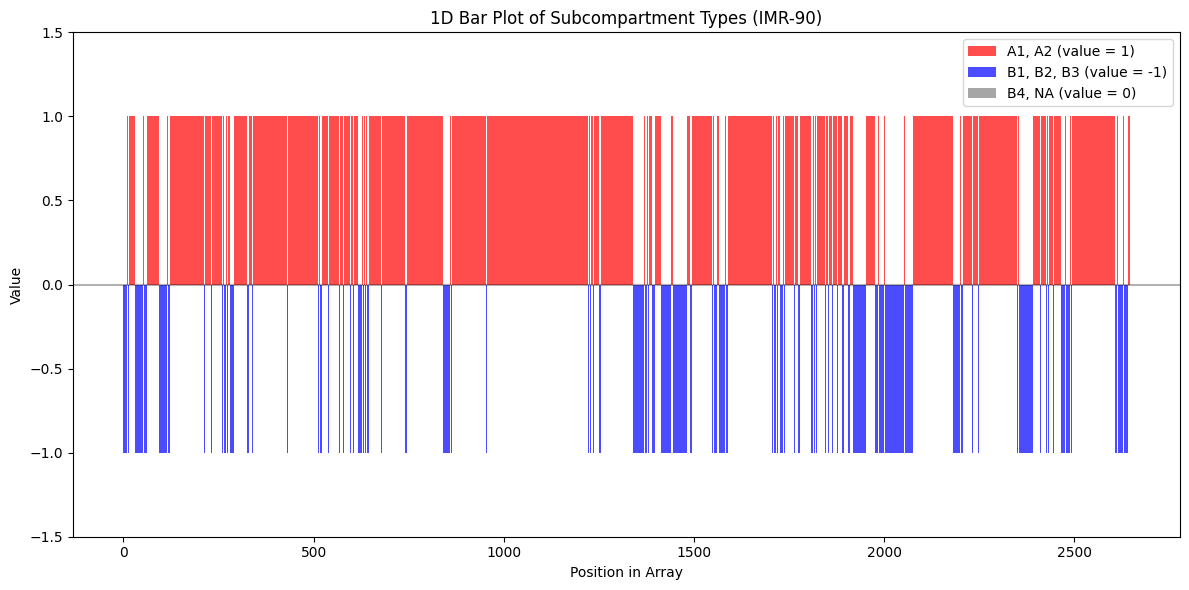

In [93]:
# Your TYPE_TO_INT mapping
TYPE_TO_INT = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'B3': 4, 'B4': 5, 'NA': 6}

# Create the mapping from integer values to plot values
# A1 (0) and A2 (1) -> 1
# B1 (2), B2 (3), B3 (4) -> -1
# B4 (5) and NA (6) -> 0
int_to_plot_value = {0: 1, 1: 1, 2: -1, 3: -1, 4: -1, 5: 0, 6: 0}

# Convert subc array to plot values
# Handle different possible data structures
try:
    # Try dictionary-like access first
    data_array = subc['IMR-90']
except (KeyError, IndexError, TypeError):
    # If that fails, assume subc is the array itself
    data_array = subc

plot_values = np.array([int_to_plot_value[val] for val in data_array])

# Create the bar plot
plt.figure(figsize=(12, 6))
colors = ['red' if val == 1 else 'blue' if val == -1 else 'gray' for val in plot_values]
plt.bar(range(len(plot_values)), plot_values, color=colors, alpha=0.7, width=1.0)

# Customize the plot
plt.xlabel('Position in Array')
plt.ylabel('Value')
plt.title('1D Bar Plot of Subcompartment Types (IMR-90)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.ylim(-1.5, 1.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='A1, A2 (value = 1)'),
                   Patch(facecolor='blue', alpha=0.7, label='B1, B2, B3 (value = -1)'),
                   Patch(facecolor='gray', alpha=0.7, label='B4, NA (value = 0)')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

Debug - Read 2636 eigenvalues
Debug - First 5 eigenvalues: [-0.013935143707296205, -0.0044513485835864985, 0.011933132965961447, 0.021842609866863646, 0.018838563050506532]
Debug - Eigenvalue range: -0.023604763278883473 to 0.03633375618393569
Debug - Array lengths: exp=2636, pred=2646, min=2636
Debug - First 10 exp values: [-1 -1  1  1  1  1  1  1  1  1]
Debug - First 10 pred values: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Debug - Unique exp values: [-1  1]
Debug - Unique pred values: [-1  1]


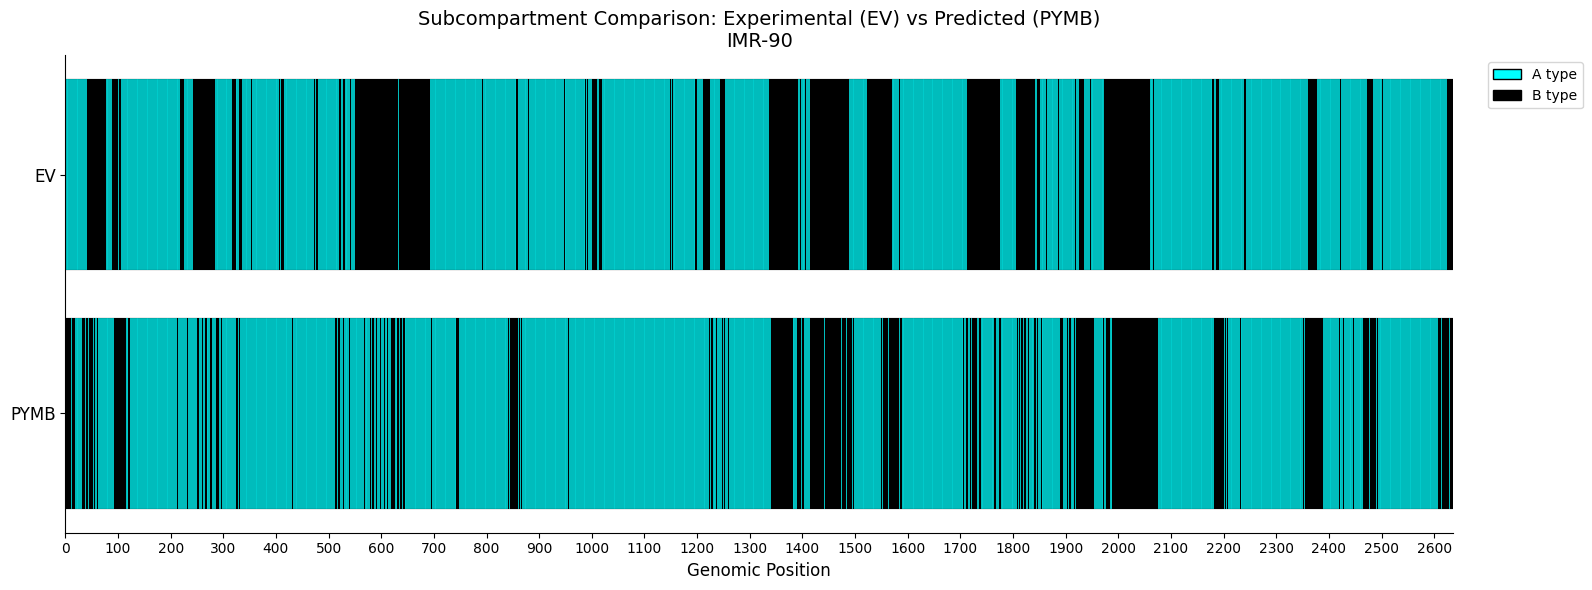


=== Data Summary ===
Total positions compared: 2636

Experimental (EV):
  A type: 1849 (70.1%)
  B type: 787 (29.9%)

Predicted (PYMB):
  A type: 1987 (75.4%)
  B type: 649 (24.6%)

Agreement:
  Matching positions: 1952/2636 (74.1%)
  Mismatched positions: 684/2636 (25.9%)

=== Type Switch Analysis ===
Experimental type switches: 143
Predicted type switches: 314

Regions of disagreement (first 10):
  Positions 2-10 (length: 9)
  Positions 13-15 (length: 3)
  Positions 17-17 (length: 1)
  Positions 31-37 (length: 7)
  Positions 39-40 (length: 2)
  Positions 43-43 (length: 1)
  Positions 52-53 (length: 2)
  Positions 56-57 (length: 2)
  Positions 59-59 (length: 1)
  Positions 62-76 (length: 15)

=== Original Data Check ===
  Type A1 (value 0): 1987 occurrences
  Type B1 (value 2): 1 occurrences
  Type B2 (value 3): 120 occurrences
  Type B3 (value 4): 528 occurrences


In [100]:
import matplotlib.pyplot as plt
import numpy as np


# chr_n = 10
# Read the eigenvalue file
eigen_values = []
with open('chr10exp_full.eigen', 'r') as f:
    for line in f:
        try:
            value = float(line.strip())
            if not np.isnan(value):  # Skip NaN values
                eigen_values.append(value)
            else:
                print(f"Skipped NaN value at line {len(eigen_values)}")
        except ValueError:
            # Skip lines that can't be converted to float
            print(f"Skipped invalid line: {line.strip()}")
            continue
eigen_values=eigen_values[20:-20] # adjust because of neighbors intervals
print(f"Debug - Read {len(eigen_values)} eigenvalues")
print(f"Debug - First 5 eigenvalues: {eigen_values[:5]}")
print(f"Debug - Eigenvalue range: {min(eigen_values)} to {max(eigen_values)}")

# CORRECTED: Normalize eigenvalues: negative -> A (1), positive -> B (-1)
experimental_values = np.array([-1 if val < 0 else 1 for val in eigen_values])

# Your TYPE_TO_INT mapping
TYPE_TO_INT = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'B3': 4, 'B4': 5, 'NA': 6}

# Create the mapping from integer values to plot values
# A1 (0) and A2 (1) -> 1 (A type)
# B1 (2), B2 (3), B3 (4), B4 (5) -> -1 (B type)
# NA (6) -> Let's map to B for now to avoid gray
int_to_plot_value = {0: 1, 1: 1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1}

# Convert subc array to plot values
try:
    data_array = subc['IMR-90']
except (KeyError, IndexError, TypeError):
    data_array = subc

predicted_values = np.array([int_to_plot_value[val] for val in data_array])

# Make sure arrays are same length for plotting
min_length = min(len(experimental_values), len(predicted_values))
exp_plot = experimental_values[:min_length]
pred_plot = predicted_values[:min_length]

# Debug prints
print(f"Debug - Array lengths: exp={len(experimental_values)}, pred={len(predicted_values)}, min={min_length}")
print(f"Debug - First 10 exp values: {exp_plot[:10]}")
print(f"Debug - First 10 pred values: {pred_plot[:10]}")
print(f"Debug - Unique exp values: {np.unique(exp_plot)}")
print(f"Debug - Unique pred values: {np.unique(pred_plot)}")

# Create the figure
fig, ax = plt.subplots(figsize=(16, 6))

# Create the data for visualization
n_positions = len(exp_plot)

# Clear any previous content
ax.clear()

# Define consistent colors: A = bright cyan blue, B = black for BOTH rows
A_COLOR = 'cyan'
B_COLOR = 'black'

# Draw rectangles for each position and row
cell_width = 1.0
cell_height = 0.8

# Draw experimental row (y=1)
for i in range(n_positions):
    if exp_plot[i] == 1:  # A type
        color = A_COLOR
    else:  # B type (-1)
        color = B_COLOR
    rect = patches.Rectangle((i, 1), cell_width, cell_height, 
                           facecolor=color, edgecolor='black', linewidth=0.1)
    ax.add_patch(rect)

# Draw predicted row (y=0)
for i in range(n_positions):
    if pred_plot[i] == 1:  # A type
        color = A_COLOR
    else:  # B type (-1)
        color = B_COLOR
    rect = patches.Rectangle((i, 0), cell_width, cell_height, 
                           facecolor=color, edgecolor='black', linewidth=0.1)
    ax.add_patch(rect)

# Set axis limits
ax.set_xlim(0, n_positions)
ax.set_ylim(-0.1, 1.9)

# Set labels and title
ax.set_yticks([0.4, 1.4])
ax.set_yticklabels(['T-D', 'EV'], fontsize=12)
ax.set_xlabel('Genomic Position', fontsize=12)
ax.set_title('Subcompartment Comparison: Experimental (EV) vs Predicted (T-D)\nIMR-90', fontsize=14)

# Set x-axis
if n_positions > 100:
    # Show every 100th position
    x_positions = list(range(0, n_positions, 100))
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(p) for p in x_positions])
else:
    # Show every 10th position
    x_positions = list(range(0, n_positions, 10))
    ax.set_xticks(x_positions)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Add legend - now same colors for both
legend_elements = [
    patches.Patch(facecolor=A_COLOR, edgecolor='black', label='A type'),
    patches.Patch(facecolor=B_COLOR, edgecolor='black', label='B type')
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f'chr{chr_n}_pred_vs_tecs.png')
plt.show()

# Print detailed statistics
print(f"\n=== Data Summary ===")
print(f"Total positions compared: {min_length}")
print(f"\nExperimental (EV):")
print(f"  A type: {np.sum(exp_plot == 1)} ({np.sum(exp_plot == 1)/min_length:.1%})")
print(f"  B type: {np.sum(exp_plot == -1)} ({np.sum(exp_plot == -1)/min_length:.1%})")

print(f"\nPredicted (PYMB):")
print(f"  A type: {np.sum(pred_plot == 1)} ({np.sum(pred_plot == 1)/min_length:.1%})")
print(f"  B type: {np.sum(pred_plot == -1)} ({np.sum(pred_plot == -1)/min_length:.1%})")

# Calculate agreement
agreements = np.sum(exp_plot == pred_plot)
print(f"\nAgreement:")
print(f"  Matching positions: {agreements}/{min_length} ({agreements/min_length:.1%})")
print(f"  Mismatched positions: {min_length-agreements}/{min_length} ({(min_length-agreements)/min_length:.1%})")

# Find type switches
print(f"\n=== Type Switch Analysis ===")
# Experimental switches
exp_switches = 0
for i in range(1, len(exp_plot)):
    if exp_plot[i] != exp_plot[i-1]:
        exp_switches += 1
print(f"Experimental type switches: {exp_switches}")

# Predicted switches
pred_switches = 0
for i in range(1, len(pred_plot)):
    if pred_plot[i] != pred_plot[i-1]:
        pred_switches += 1
print(f"Predicted type switches: {pred_switches}")

# Find regions of disagreement
disagreements = []
in_disagreement = False
start = 0

for i in range(min_length):
    if exp_plot[i] != pred_plot[i]:
        if not in_disagreement:
            start = i
            in_disagreement = True
    else:
        if in_disagreement:
            disagreements.append((start, i-1))
            in_disagreement = False

if in_disagreement:
    disagreements.append((start, min_length-1))

if disagreements:
    print(f"\nRegions of disagreement (first 10):")
    for start, end in disagreements[:10]:
        print(f"  Positions {start}-{end} (length: {end-start+1})")

# Check original data mapping
print(f"\n=== Original Data Check ===")
unique_vals, counts = np.unique(data_array[:min_length], return_counts=True)
for val, count in zip(unique_vals, counts):
    type_name = [k for k, v in TYPE_TO_INT.items() if v == val][0]
    print(f"  Type {type_name} (value {val}): {count} occurrences")

In [102]:
# Add this code at the end of your existing script

# Create reverse mapping from integer to type name
INT_TO_TYPE = {v: k for k, v in TYPE_TO_INT.items()}

# Export predictions to text file
output_filename = f'chr{chr_n}_predictions_IMR90_GRCh38.txt'

with open(output_filename, 'w') as f:
    # Get the full data array (not truncated)
    try:
        full_data_array = subc['IMR-90']
    except (KeyError, IndexError, TypeError):
        full_data_array = subc
    
    # Write each prediction on a new line with index (starting from 1)
    for i, value in enumerate(full_data_array, start=1):
        type_name = INT_TO_TYPE.get(value, 'NA')
        f.write(f"{i} {type_name}\n")

print(f"\n=== Export Complete ===")
print(f"Predictions exported to: {output_filename}")
print(f"Total predictions exported: {len(full_data_array)}")

# Show first 10 predictions as preview
print("\nFirst 10 predictions:")
for i in range(min(10, len(full_data_array))):
    type_name = INT_TO_TYPE.get(full_data_array[i], 'NA')
    print(f"  {i+1} {type_name}")

# Count occurrences of each type
type_counts = {}
for value in full_data_array:
    type_name = INT_TO_TYPE.get(value, 'NA')
    type_counts[type_name] = type_counts.get(type_name, 0) + 1

print("\nSummary of predictions:")
for type_name, count in sorted(type_counts.items()):
    print(f"  {type_name}: {count} occurrences ({count/len(full_data_array)*100:.1f}%)")


=== Export Complete ===
Predictions exported to: chr10_predictions_IMR90_GRCh38.txt
Total predictions exported: 2646

First 10 predictions:
  1 B2
  2 B2
  3 B2
  4 B3
  5 B3
  6 B3
  7 B3
  8 B2
  9 B2
  10 B2

Summary of predictions:
  A1: 1991 occurrences (75.2%)
  B1: 1 occurrences (0.0%)
  B2: 122 occurrences (4.6%)
  B3: 532 occurrences (20.1%)
